# Housing Price Prediction using Yggdrasil Decision Forests (YDF)

This notebook presents a complete machine learning pipeline for predicting housing prices using Yggdrasil Decision Forests (YDF). The focus is on building a well-structured, domain-aware, and reproducible workflow.

## Key Objectives

- Perform robust data preprocessing with special attention to domain-specific feature groups (e.g., Garage, Basement).
- Preserve the semantic meaning of missing values where applicable.
- Prepare categorical and numerical features in alignment with YDF’s native handling capabilities.
- Train and evaluate models using YDF with minimal manual imputation or encoding.
- Maintain clean, modular code with clarity in feature selection, transformation, and model logic.

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import ydf
from sklearn.metrics import mean_squared_error, r2_score
import pickle


pd.set_option('display.max_columns', None)

## Custom Data Cleaning Function: `fix_inconsistent_group`
Standardizes feature groups like Garage, Basement, etc., handling categorical NaNs and corresponding numeric zeros.

In [3]:
def fix_inconsistent_group(df, key, zero_means_absence_map):
    """
    Harmonize feature indicators by resolving mixed signals of presence/absence.

    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with potentially inconsistent categorical and numeric indicators.
    key : str
        Feature group to assess (e.g., 'Garage', 'Basement').
    zero_means_absence_map : dict
        Maps feature groups to numeric columns where zero implies absence.

    Returns:
    --------
    pd.DataFrame
        Updated DataFrame with standardized absence representation.
    """
    
    # Identify categorical columns related to the feature key
    cat_cols = [col for col in df.columns if key in col.lower() and df[col].dtype == 'object']
    zero_cols = zero_means_absence_map.get(key, [])

    def fix_row(row):
        # Count missing and present values in categorical columns
        n_cat_na = row[cat_cols].isna().sum()
        n_cat_valid = row[cat_cols].notna().sum()

        # Count zeros and positive values in relevant numeric columns
        n_zero = sum((row[col] == 0) for col in zero_cols if pd.notna(row[col]))
        n_pos = sum((row[col] > 0) for col in zero_cols if pd.notna(row[col]))

        # If more indicators point to absence than presence, standardize the row
        if (n_cat_na + n_zero) > (n_cat_valid + n_pos):
            for col in cat_cols:
                row[col] = f'No{key.capitalize()}'
            row[zero_cols] = 0  # Set only zero-flag numeric columns to 0
        
        return row

    return df.apply(fix_row, axis=1)

## Main Data Wrangling Function
This function:
- Loads the dataset.
- Applies standardization on inconsistent feature groups.
- Creates engineered features.
- Drops leakage-prone or non-useful columns.
- Converts low-cardinality numerics into categorical types.

In [4]:
def wrangle(train_filepath):
    """
    Perform domain-aware data wrangling for housing price prediction.

    Parameters:
    -----------
    train_filepath : str
        Path to the raw training CSV file.

    Returns:
    --------
    pd.DataFrame
        Cleaned and feature-engineered dataset ready for modeling.
    """

    # Load dataset
    df = pd.read_csv(train_filepath)

    # Define groups where zero in numeric column implies absence of corresponding feature
    zero_means_absence_map = {
        "bsmt": ["TotalBsmtSF"],
        "garage": ["GarageArea"],
        "fireplace": ["Fireplaces"],
        "pool": ["PoolArea"],
        "masvnr": ["MasVnrArea"]
    }

    # Feature groups that require consistency checks and NaN preservation
    feature_keys = ["bsmt", "garage", "fireplace", "pool", "masvnr", "alley", "fence", "miscfeature"]

    # Apply consistent missing value logic for grouped features
    for key in feature_keys:
        df = fix_inconsistent_group(df, key, zero_means_absence_map)

    # Feature engineering: Number of years before the house was remodeled
    df["YearsUntilRemodel"] = df["YearRemodAdd"] - df["YearBuilt"]

    # Drop columns that may cause data leakage or are irrelevant to modeling
    drop_cols = ["Id", "MoSold", "YrSold", "SaleType", "SaleCondition"]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Convert low-cardinality numerical features into categorical dtype
    likely_categoricals = [
        col for col in df.columns
        if df[col].nunique() < 16 and df[col].dtype in ['int64', 'float64']
    ]
    df[likely_categoricals] = df[likely_categoricals].apply(
        lambda col: col.map(lambda x: "" if pd.isna(x) else str(x)).astype('category')
    )

    return df

## Apply Data Wrangling
Load and clean the training data using the `wrangle()` function.

In [5]:
train_filepath = "data/train.csv"
df = wrangle(train_filepath)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SalePrice,YearsUntilRemodel
0,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoFireplace,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPool,NoFence,NoMiscfeature,0,208500,0
1,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NoPool,NoFence,NoMiscfeature,0,181500,0
2,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NoPool,NoFence,NoMiscfeature,0,223500,1
3,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NoPool,NoFence,NoMiscfeature,0,140000,55
4,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NoPool,NoFence,NoMiscfeature,0,250000,0


#### Visualizing the distribution of the target variable

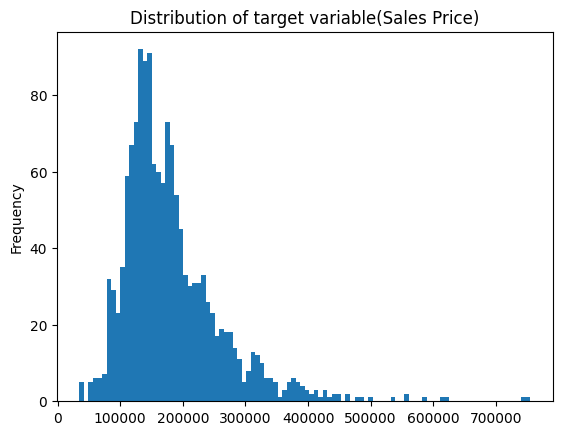

In [6]:
# Histogram to assess skewness and spread of SalePrice
df['SalePrice'].plot(kind='hist', 
                     bins=100, 
                     title="Distribution of target variable(Sales Price)",
                     xlabel='Price');

#### Exploring distributions of all numeric features

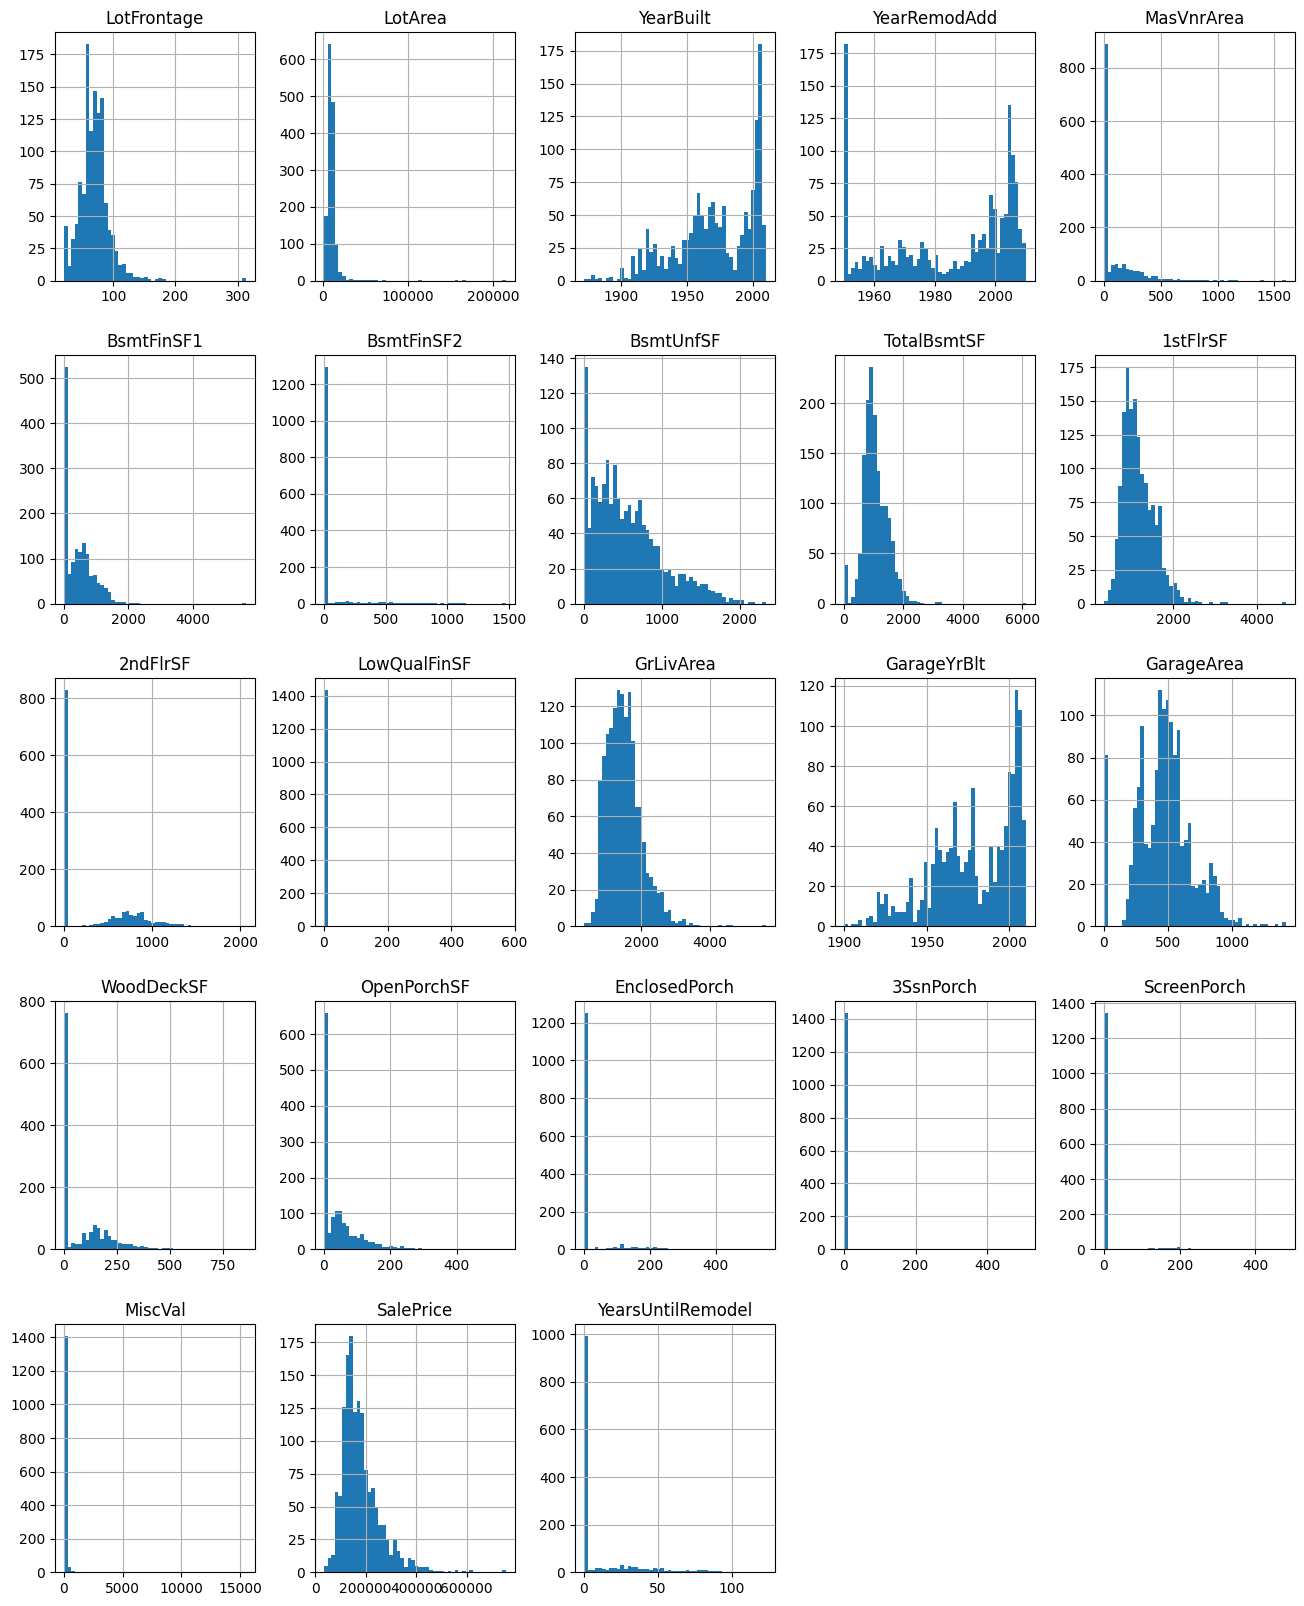

In [7]:
# Quick scan of distributions for all numeric columns
numeric_features = df.select_dtypes(include=['int64', 'float64'])
numeric_features.hist(bins=50, figsize=(16,20));

#### Correlation of numeric features with SalePrice

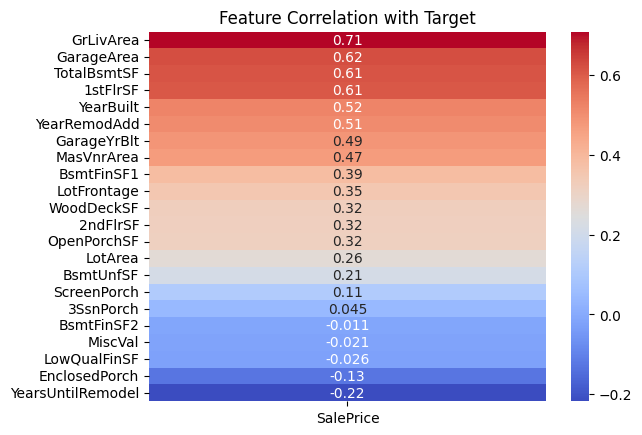

In [8]:
# Correlation heatmap: how strongly each numeric feature relates to SalePrice
target_corr = df.select_dtypes(include=['number']).corr()['SalePrice'].drop('SalePrice')
target_corr = target_corr.sort_values(ascending=False)

sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Target')
plt.show()

### Train-validation split for model evaluation

In [9]:
# Split dataset for validation: 80% train, 20% validation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

#### Baseline RMSE using mean SalePrice

In [10]:
# Baseline: predict mean SalePrice for all validation samples
baseline_pred = [train_df['SalePrice'].mean()] * len(test_df['SalePrice'])
rmse_baseline = mean_squared_error(test_df['SalePrice'], baseline_pred)
rmse_baseline

7677095207.783831

## Train Random Forest model using a YDF hyperparameter template

In [11]:
def train_randomforestlearner_model_with_template(template_name: str, train_df, label="SalePrice"):
    """
    Train a YDF Random Forest model using a predefined hyperparameter template.
    
    Parameters:
    -----------
    template_name : str
    Name of the hyperparameter template from YDF.
    train_df : pd.DataFrame
    Training dataset.
    label : str
    Target column for regression (default is 'SalePrice').
    
    Returns:
    --------
    Trained YDF model object.
    """
    # Initialize and train model with template-defined hyperparameters
    learner = ydf.RandomForestLearner(
    label=label,
    include_all_columns=True,
    **ydf.RandomForestLearner.hyperparameter_templates()[template_name],
    task=ydf.Task.REGRESSION
    )
    
    model = learner.train(train_df)
    return model

## Train Gradient Boosted Trees model using a YDF hyperparameter template

In [12]:
def train_gradientboostedtreeslearner_model_with_template(template_name: str, train_df, label="SalePrice"):
    """
    Train a YDF Gradient Boosted Trees model using a predefined hyperparameter template.

    Parameters:
    -----------
    template_name : str
        Name of the hyperparameter template from YDF.
    train_df : pd.DataFrame
        Training dataset.
    label : str
        Target column for regression (default is 'SalePrice').

    Returns:
    --------
    Trained YDF model object.
    """
    # Initialize and train model with template-defined hyperparameters
    learner = ydf.GradientBoostedTreesLearner(
    label=label,
    include_all_columns=True,
    **ydf.GradientBoostedTreesLearner.hyperparameter_templates()[template_name],
    task=ydf.Task.REGRESSION
    )
    
    model = learner.train(train_df)
    return model

### Training Random Forest and Gradient Boosted Trees models with different templates

In [13]:
# Train Random Forest and Gradient Boosted Trees models with different hyperparameter templates
rf1 = train_randomforestlearner_model_with_template("better_defaultv1", train_df)
rf2 = train_randomforestlearner_model_with_template("benchmark_rank1v1", train_df)
gbt1 = train_gradientboostedtreeslearner_model_with_template("better_defaultv1", train_df)
gbt2 = train_gradientboostedtreeslearner_model_with_template("benchmark_rank1v1", train_df)

[Warning] Column 'MSSubClass' is detected as CATEGORICAL but its values look like numbers (e.g., b'180, 20, 75'). Should the column not be NUMERICAL instead? If so, feed numerical values instead of strings or objects.
Column 'OverallQual' is detected as CATEGORICAL but its values look like numbers (e.g., b'3, 4, 8'). Should the column not be NUMERICAL instead? If so, feed numerical values instead of strings or objects.
Column 'OverallCond' is detected as CATEGORICAL but its values look like numbers (e.g., b'4, 3, 8'). Should the column not be NUMERICAL instead? If so, feed numerical values instead of strings or objects.
Column 'BsmtFullBath' is detected as CATEGORICAL but its values look like numbers (e.g., b'2, 1, 0'). Should the column not be NUMERICAL instead? If so, feed numerical values instead of strings or objects.
Column 'BsmtHalfBath' is detected as CATEGORICAL but its values look like numbers (e.g., b'1, 0'). Should the column not be NUMERICAL instead? If so, feed numerical v

Train model on 1168 examples
Model trained in 0:00:00.393355
Train model on 1168 examples
Model trained in 0:00:01.262156
Train model on 1168 examples
Model trained in 0:00:01.401434
Train model on 1168 examples
Model trained in 0:00:01.794077


### Evaluate model performance: RMSE and R²

In [14]:
def evaluate_model(model, df):
    """
    Evaluate model performance on the given dataset using RMSE and R².

    Parameters:
    -----------
    model : Trained model object
        The model to evaluate.
    df : pd.DataFrame
        DataFrame containing the true values and features.

    Returns:
    --------
    list : [rmse, r2]
        RMSE and R² scores for the model's predictions.
    """
    # Predict target variable and calculate performance metrics
    y_pred = model.predict(df)
    y_true = df['SalePrice']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return [rmse, r2]

#### Evaluate models on the validation set and store results

In [15]:
# Evaluate each model on the validation set and store RMSE and R² results
results = {}
models = {'rf1': rf1,
          'rf2': rf2,
          'gbt1': gbt1,
          'gbt2': gbt2}
for model_name, model in models.items():
    results[model_name] = evaluate_model(model, test_df)
val_results = pd.DataFrame(results, index=['rmse', 'r2']).T
val_results

,rmse,r2
rf1,28988.265764,0.890445
rf2,30211.295371,0.881006
gbt1,24519.539311,0.921619
gbt2,26513.086278,0.908355


#### Evaluate Gradient Boosted Trees model (gbt1) on the validation set

In [16]:
# Evaluate gbt1 model on the validation set
gbt1.evaluate(test_df)

Evaluation()

#### Final model selection
The final model is selected based on RMSE and R² scores. Gradient Boosted Trees with the "better_defaultv1" template is chosen.

In [17]:
# Display summary of the final model
gbt1.describe()

### Save and Load Trained Model

In [18]:
# Save your trained model to a directory
gbt1.save("models/house_price_model")

In [19]:
# Load the model from the directory
model = ydf.load_model("models/house_price_model")